<img align="right" style="max-width: 200px; height: auto" src="https://github.com/financial-data-science/CFDS/blob/master/lab_04/cfds_logo.png?raw=1">

###  Lab 04 - "Mean Reversion Trading Strategies"

Chartered Financial Data Scientist (CFDS), Spring Term 2020

In this introductory lab, we create our first **financial data science process**. The main objective of this lab is to walk you through the general process of implementing and evaluating a simple **mean-reversion** trading strategy. To achieve this, we will follow the distinct process steps as outlined below:

<img align="middle" style="max-width: 600px; height: auto" src="https://github.com/financial-data-science/CFDS/blob/master/lab_04/fds_process.png?raw=1">

As always, pls. don't hesitate to ask all your questions either during the lab or send us an email (using our
fds.ai email addresses).

### Lab Objectives:

After today's lab you should be able to:
    
> 1. Implement a **mean-reversion trading strategy** and apply it to distinct financial instruments.
> 2. Convert the trading strategy results into **trade signals** to be used in backtest.
> 3. Understand how to use the **python backtesting bt** library to backtest the implemented strategy.
> 4. Interpret the backtests results using the distinct **backtest performance** measures.

Before we start let's watch a motivational video:

In [1]:
from IPython.display import YouTubeVideo
# Nvidia GTC 2017: "I Am AI" Opening in Keynote"
# YouTubeVideo('SUNPrR4o5ZA', width=800, height=600)

### Setup of the Analysis Environment

We need to import a couple of Python libraries that allow for data analysis and data visualization. In this lab will use the `Pandas`, `NumPy`, `BT` and the `Matplotlib` library. Let's import the libraries by the execution of the statements below:

In [4]:
# import python utility libraries
import os as os
import datetime as dt
import itertools as it

# import python data science libraries
import pandas as pd
import numpy as np

# import the pandas financial data reader library
import pandas_datareader as dr

# import the matplotlib and seaborn visualization library
import matplotlib.pyplot as plt
import seaborn as sns

Install the Python `BT` backtesting library:

Upon successful installation let's import the Python `BT` backtesting library:

In [5]:
import bt as bt # library to backtest trading signals

Let's also set a couple of general plot parameters:

In [6]:
import warnings
warnings.filterwarnings('ignore')

Create a **dataset** sub-folder that we will use to store the financial data downloaded:

In [7]:
if not os.path.exists('./datasets'): os.makedirs('./datasets')

### 1. Acquire the Financial Data

In this section of the lab notebook, we will aquire historic daily stock market data of the **Euro vs. US-Dollar** foreign exchange rate (ticker symbol: "EURUSD"). Thereby, we will utilize the `datareader` of the `Pandas` library that provides the ability to interface the `Yahoo` finance API. Let's first specify the start date and end date of the data download. We aim to download the exchange rate data starting from the **31.12.2003** until the **31.12.2017** to develop and evaluate a simple mean-reversion trading strategy:

In [8]:
# set to start and end date of the data download
start_date = dt.datetime(2003, 12, 31)
end_date = dt.datetime(2017, 12, 31)

Download the **daily** "Euro vs. USD" exchange rate data of the defined timeframe using the `datareader`'s `Yahoo` finance API:

In [9]:
# download eurusd exchange rate data

path = 'data/eurusd_data_2003_2017_daily.csv'
eurusd_data =  pd.read_csv(path, sep="," )#.dropna()
eurusd_data['Date'] = pd.to_datetime(eurusd_data['Date'])
eurusd_data=eurusd_data.set_index('Date')#.rename(columns = {'Adj_Close':'Adj Close'})
#ibm_data = ibm_data.iloc[1:]

### 2. Pre-Process the Financial Data

Inspect the top 10 records of the `EURUSD` data downloaded:

In [10]:
eurusd_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-31,1.255004,1.264894,1.253007,1.259002,1.259002,0
2004-01-01,1.259002,1.260796,1.247396,1.258194,1.258194,0
2004-01-02,1.258194,1.262802,1.252693,1.258194,1.258194,0
2004-01-05,1.263903,1.269406,1.263695,1.268698,1.268698,0
2004-01-06,1.268907,1.280803,1.267202,1.272103,1.272103,0
2004-01-07,1.272394,1.273999,1.262499,1.264095,1.264095,0
2004-01-08,1.264095,1.278707,1.256502,1.277498,1.277498,0
2004-01-09,1.277498,1.286703,1.271294,1.285892,1.285892,0
2004-01-12,1.284802,1.289707,1.273804,1.274096,1.274096,0


Visually inspect the **adjusted closing price** of the downloaded `EURUSD`
 data:

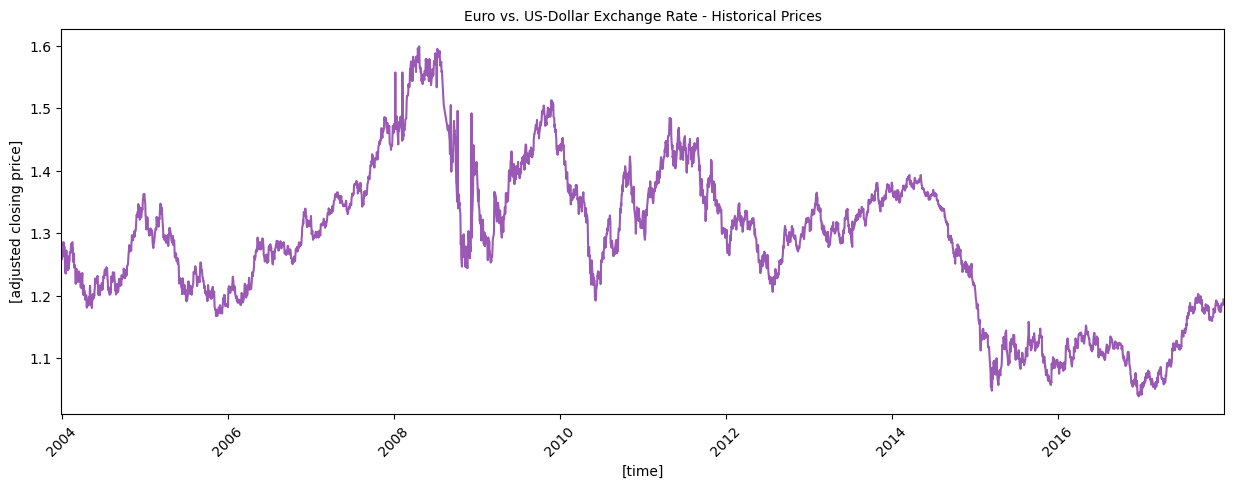

In [11]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot eurusd daily adjusted closing prices
ax.plot(eurusd_data.index, eurusd_data['Adj Close'], color='#9b59b6')

# rotate x-ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[adjusted closing price]', fontsize=10)

# set plot title
plt.title('Euro vs. US-Dollar Exchange Rate - Historical Prices', fontsize=10);

Save the downloaded `EURUSD` data to the local directory:

In [12]:
eurusd_data.to_csv('./datasets/eurusd_data_2003_2017_daily.csv', sep=';', encoding='utf-8')

### 3. Data Analysis - Mean Reversion Strategy Implementation

Let's implement a simple **Mean Reversion** trading strategy. In general, **mean reversion trading** refers to the idea that extreme market movements are more likely followed by an "average movement" than by an even more extreme market movement.

Mean reversion trading is derived from the observation that the price of financial instruments tend to **revert to their mean price** over time. It is assumed, that the price of a financial instrument is prone to random fluctuations around an underlying (potentially) stable trend. This behaviour can be frequently observed when analyzing price charts of foreign exchange rates such as the EUR to JPY fx-rate, as observable in the following illustration:

<img align="middle" style="max-width: 800px; height: auto" src="https://github.com/financial-data-science/CFDS/blob/master/lab_04/meanreversiontrend.png?raw=1">

In the context of mean reversion trading it is aimed to trade such (tiny) fluctuations around such more stable trends. To achieve this will, we apply a technique referred to as **"Bollinger Bands"** proposed by John Bollinger in the 1980's. Bollinger Bands characterize the price volatility of a financial instrument over time. In general, the bands are determined by:


$$BB^{upper}(t, n, k) = SMA(t, n) + k \cdot \sigma(t)$$

$$BB^{lower}(t, n, k) = SMA(t, n) - k \cdot \sigma(t)$$


where $t$ denotes the current point in time and the distinct elements of the Bollinger Bands calculation correspond to:

>- $SMA(t, n)$ denotes a **simple moving average** with a lookback window of $n$ historical prices $p_i$ defined by $SMA(t, n)=\frac{1}{n} \sum_{k=0}^{n-1} p_{i}(t-k)$, e.g. a 20, 50, or 100-days moving average lookback window;
>- $BB^{upper}(t, n, k)$ denotes the **upper Bollinger Band** defined by adding $k$-times the positive standard deviation $\sigma_i$ of the $n$ historical prices $p_i$ to the simple moving average $SMA(t, n)$; and,
>- $BB^{lower}(t, n, k)$ denotes the **lower Bollinger Band** defined by subtracting $k$-times the positive standard deviation $\sigma_i$ of the $n$ historical prices $p_i$ from the simple moving average $SMA(t, n)$.

The following illustration shows the calculated Bollinger Bands $BB^{upper}$ and $BB^{lower}$ at distinct timesteps $t$ and different $k$ parametrizations:

<img align="middle" style="max-width: 800px; height: auto" src="https://github.com/financial-data-science/CFDS/blob/master/lab_04/bollingerbands.png?raw=1">

Let's start inspect the Bollinger Bands of the mean-reversion trading strategy by setting the moving average window lookback size:

In [13]:
mre_lookback_days_20 = 20   # set the mean-reversion moving average indicator lookback, days = 20

We can calculate the moving (rolling) average using the Pandas `rolling()` and `mean()` function:

In [14]:
mre_mav_20 = pd.Series(eurusd_data['Adj Close'].rolling(window = mre_lookback_days_20).mean(), name = 'SMAV_20')

Similarly, we can calculate the moving (rolling) standard deviation $\sigma$ using the Pandas `rolling()` and `std()` function:

In [15]:
mre_std_20 = pd.Series(eurusd_data['Adj Close'].rolling(window = mre_lookback_days_20).std(), name = 'STD_20')

Merge the obtained rolling moving average and standard deviation values with the original echange rate price data (adjusted closing prices):

In [16]:
mre_mav_eurusd_data = eurusd_data.join(mre_mav_20)
mre_mav_eurusd_data = mre_mav_eurusd_data.join(mre_std_20)

Inspect and validate the daily adjusted closing prices of the EURUSD exchange rate as well as the derived (i) moving average and (ii) standard deviation values starting from the first obtained 20-day moving average price:

In [17]:
mre_mav_eurusd_data[['Adj Close', 'SMAV_20', 'STD_20']].iloc[20:30]

,Adj Close,SMAV_20,STD_20
Date,,,
2004-01-28,1.244199,1.262504,0.013107
2004-01-29,1.241003,1.261645,0.013941
2004-01-30,1.246805,1.261075,0.014317
2004-02-02,1.243302,1.259805,0.014726
2004-02-03,1.253494,1.258875,0.014494
2004-02-04,1.253997,1.258370,0.014479
2004-02-05,1.257197,1.257355,0.013761
2004-02-06,1.270002,1.256561,0.012420
2004-02-09,1.269406,1.256326,0.012112


To gain an even more detailed intuition let's determine and visualize different degrees of rolling standard deviation obtainable from the 20-day moving average price. Obtain a rolling adjusted closing price standard deviation of $\sigma = \pm 1$:

In [18]:
# one standard deviations
mre_mav_eurusd_data['POS_STD1_20'] = mre_mav_eurusd_data['Adj Close'] + (1.0 * mre_mav_eurusd_data['STD_20'])
mre_mav_eurusd_data['NEG_STD1_20'] = mre_mav_eurusd_data['Adj Close'] - (1.0 * mre_mav_eurusd_data['STD_20'])

Similarly, obtain a rolling adjusted closing price standard deviation of $\sigma = \pm 2$:

In [19]:
# two standard deviations
mre_mav_eurusd_data['POS_STD2_20'] = mre_mav_eurusd_data['Adj Close'] + (2.0 * mre_mav_eurusd_data['STD_20'])
mre_mav_eurusd_data['NEG_STD2_20'] = mre_mav_eurusd_data['Adj Close'] - (2.0 * mre_mav_eurusd_data['STD_20'])

And finally, obtain a rolling adjusted closing price standard deviation of $\sigma = \pm 3$:

In [20]:
# three standard deviations
mre_mav_eurusd_data['POS_STD3_20'] = mre_mav_eurusd_data['Adj Close'] + (3.0 * mre_mav_eurusd_data['STD_20'])
mre_mav_eurusd_data['NEG_STD3_20'] = mre_mav_eurusd_data['Adj Close'] - (3.0 * mre_mav_eurusd_data['STD_20'])

Inspect and validate the daily adjusted closing prices of the EURUSD exchange rate as well the different degrees of deviating standard deviations starting from the first obtained 20-day moving average price:

In [21]:
mre_mav_eurusd_data[['Adj Close', 'SMAV_20', 'STD_20', 'POS_STD1_20', 'NEG_STD1_20', 'POS_STD2_20', 'NEG_STD2_20', 'POS_STD3_20', 'NEG_STD3_20']].iloc[20:30]

,Adj Close,SMAV_20,STD_20,POS_STD1_20,NEG_STD1_20,POS_STD2_20,NEG_STD2_20,POS_STD3_20,NEG_STD3_20
Date,,,,,,,,,
2004-01-28,1.244199,1.262504,0.013107,1.257306,1.231092,1.270412,1.217985,1.283519,1.204879
2004-01-29,1.241003,1.261645,0.013941,1.254944,1.227061,1.268886,1.213120,1.282827,1.199178
2004-01-30,1.246805,1.261075,0.014317,1.261122,1.232488,1.275440,1.218170,1.289757,1.203853
2004-02-02,1.243302,1.259805,0.014726,1.258028,1.228576,1.272754,1.213849,1.287480,1.199123
2004-02-03,1.253494,1.258875,0.014494,1.267988,1.239000,1.282483,1.224506,1.296977,1.210011
2004-02-04,1.253997,1.258370,0.014479,1.268476,1.239518,1.282955,1.225040,1.297433,1.210561
2004-02-05,1.257197,1.257355,0.013761,1.270958,1.243437,1.284719,1.229676,1.298480,1.215915
2004-02-06,1.270002,1.256561,0.012420,1.282422,1.257582,1.294842,1.245162,1.307262,1.232742
2004-02-09,1.269406,1.256326,0.012112,1.281518,1.257294,1.293630,1.245182,1.305742,1.233070


Plot the historical daily adjusted closing prices of the EUR vs. US-Dollar (blue) as well as its rolling 20 days standard deviations of $\sigma=1$ standard deviations (top), $\sigma=2$ standard deviations (middle) as well as $\sigma=3$ standard deviations (bottom):

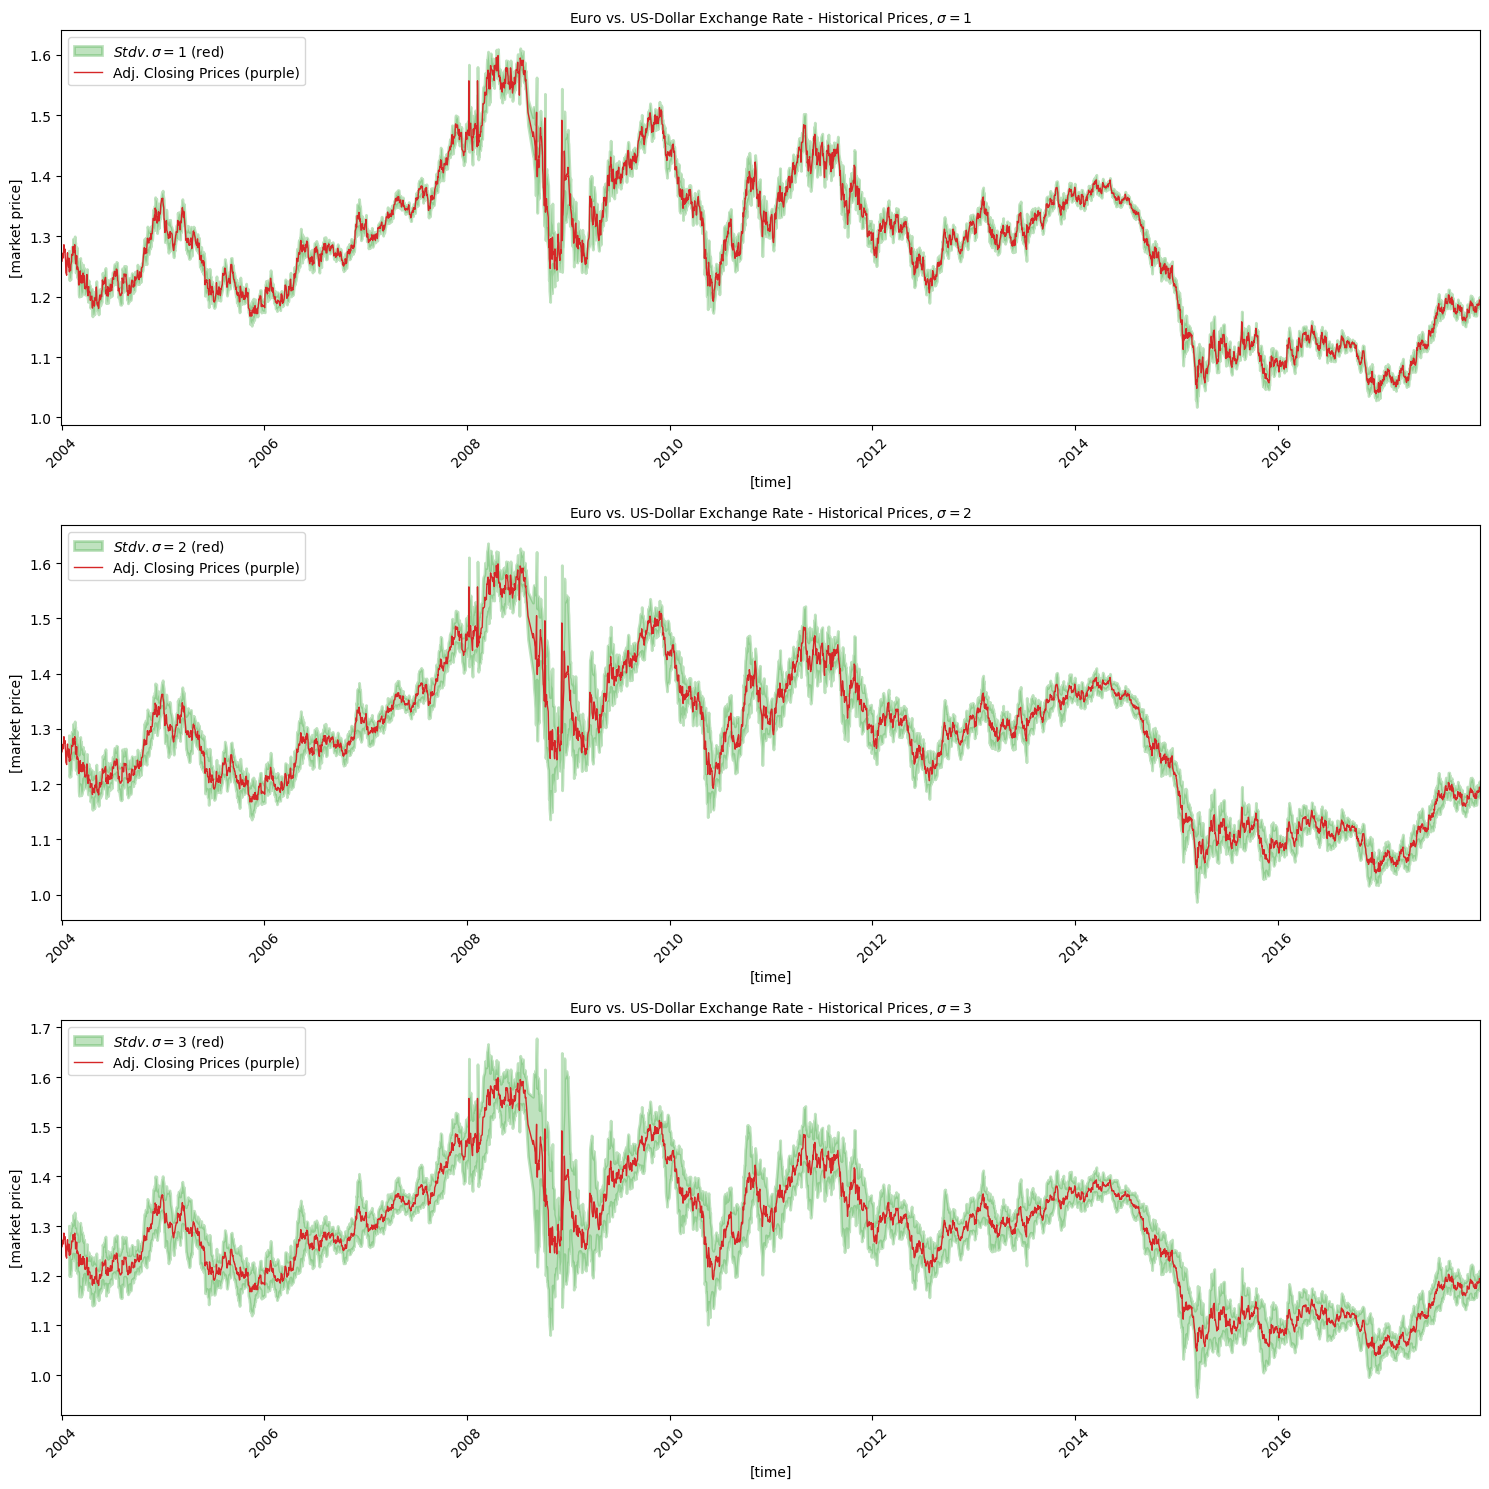

In [22]:
plt.rcParams['figure.figsize'] = [15, 15]
fig, ax = plt.subplots(ncols=1, nrows=3)

#### plot the standard deviation of 1

# plot moving average adjusted closing price standard deviation of 1
ax[0].fill_between(mre_mav_eurusd_data.index, mre_mav_eurusd_data['POS_STD1_20'], mre_mav_eurusd_data['NEG_STD1_20'], color='C2', lw=2.0, label='$Stdv. \sigma = 1$ (red)', alpha=0.3)

# plot adjusted closing price
ax[0].plot(mre_mav_eurusd_data['Adj Close'], lw=1.0, color='C3', label='Adj. Closing Prices (purple)')

# rotate x-tick labels
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax[0].set_xlabel('[time]', fontsize=10)
ax[0].set_xlim([start_date, end_date])
ax[0].set_ylabel('[market price]', fontsize=10)

# set plot legend
ax[0].legend(loc="upper left", numpoints=1, fancybox=True)

#### plot the standard deviation of 2

# plot moving average adjusted closing price standard deviation of 2
ax[1].fill_between(mre_mav_eurusd_data.index, mre_mav_eurusd_data['POS_STD2_20'], mre_mav_eurusd_data['NEG_STD2_20'], color='C2', lw=2.0, label='$Stdv. \sigma = 2$ (red)', alpha=0.3)

# plot adjusted closing price
ax[1].plot(mre_mav_eurusd_data['Adj Close'], lw=1.0, color='C3', label='Adj. Closing Prices (purple)')

# rotate x-tick labels
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax[1].set_xlabel('[time]', fontsize=10)
ax[1].set_xlim([start_date, end_date])
ax[1].set_ylabel('[market price]', fontsize=10)

# set plot legend
ax[1].legend(loc="upper left", numpoints=1, fancybox=True)

#### plot the standard deviation of 3

# plot moving average adjusted closing price standard deviation of 3
ax[2].fill_between(mre_mav_eurusd_data.index, mre_mav_eurusd_data['POS_STD3_20'], mre_mav_eurusd_data['NEG_STD3_20'], color='C2', lw=2.0, label='$Stdv. \sigma = 3$ (red)', alpha=0.3)

# plot adjusted closing price
ax[2].plot(mre_mav_eurusd_data['Adj Close'], lw=1.0, color='C3', label='Adj. Closing Prices (purple)')

# rotate x-tick labels
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax[2].set_xlabel('[time]', fontsize=10)
ax[2].set_xlim([start_date, end_date])
ax[2].set_ylabel('[market price]', fontsize=10)

# set plot legend
ax[2].legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
ax[0].set_title('Euro vs. US-Dollar Exchange Rate - Historical Prices, $\sigma=1$', fontsize=10)
ax[1].set_title('Euro vs. US-Dollar Exchange Rate - Historical Prices, $\sigma=2$', fontsize=10)
ax[2].set_title('Euro vs. US-Dollar Exchange Rate - Historical Prices, $\sigma=3$', fontsize=10)

# reset plot layout
plt.tight_layout()

### 4. Mean Reversion Trading Signal Generation

We will make use of the **"Standard-Score"** or **"Z-Score"** to convert the Bollinger Band information into a series of binary long- and short-trading-signals of a mean reversion trading strategy. The **"Z-Score"** is the signed number of standard deviations by which the actual price $p_{i}(t)$ of a financial instrument $i$ falls above or below the moving average price, formally denoted by:

$$ z_{i}(t) = \frac{p_{i}(t)-SMA_{i}(t,n)}{\sigma_{i}(t, n)}$$

where $t$ denotes the current point in time and the distinct elements of the Z-Score are defined by:

>- $SMA(t, n)$ denotes a **simple moving average** with a lookback window of $n$ historical prices $p_i$ defined by $SMA(t, n)=\frac{1}{n} \sum_{k=0}^{n-1} p_{i}(t-k)$, e.g. a 20, 50, or 100-days moving average lookback window; and,
>- $\sigma_{i}(t, n)$ denotes the **moving average strandard deviation** with a lookback window of $n$ historical prices $p_i$, e.g. a 20, 50, or 100-days moving average lookback window.

Let's now determine the Z-Score at distinct time steps of the EUR vs. US-Dollar foreign exchange rate:

In [23]:
mre_mav_eurusd_data['Z_SCORE'] = (mre_mav_eurusd_data['Adj Close'] - mre_mav_eurusd_data['SMAV_20']) / mre_mav_eurusd_data['STD_20']

Inspect and validate the different rolling Z scores obtained, starting from the first obtained 20-day moving average price:

In [24]:
mre_mav_eurusd_data[['Adj Close', 'SMAV_20', 'STD_20', 'Z_SCORE']].iloc[20:30]

,Adj Close,SMAV_20,STD_20,Z_SCORE
Date,,,,
2004-01-28,1.244199,1.262504,0.013107,-1.396632
2004-01-29,1.241003,1.261645,0.013941,-1.480620
2004-01-30,1.246805,1.261075,0.014317,-0.996705
2004-02-02,1.243302,1.259805,0.014726,-1.120719
2004-02-03,1.253494,1.258875,0.014494,-0.371248
2004-02-04,1.253997,1.258370,0.014479,-0.302031
2004-02-05,1.257197,1.257355,0.013761,-0.011451
2004-02-06,1.270002,1.256561,0.012420,1.082279
2004-02-09,1.269406,1.256326,0.012112,1.079927


Let's now derive a mean-reversion trading signal from the calculated rolling Z-Score of the EUR vs. US-Dollar foreign exchange rate. In order to derive such a signal we first specify an upper Z-Score threshold $\alpha$ and a lower Z-Score threshold $\beta$, where $\alpha > \beta$. Afterwards, we are able to derive a mean-reversion trading signal according to the following rules:

>- **"Long-signal"** (+1.0) signal if $z_{i}(t) \leq -\; \alpha \cdot z_{i}(t)$;
>- **"Close Long-signal"** (0.0) signal if $z_{i}(t) \leq -\; \beta \cdot z_{i}(t)$;
>- **"Short-signal"** (+1.0) signal if $z_{i}(t) \geq +\; \alpha \cdot z_{i}(t)$; and,
>- **"Close Short-signal"** (0.0) signal if $z_{i}(t) \geq +\; \beta \cdot z_{i}(t)$.

Let's now start to determine the mean-reversion trading signals by setting the Z-Score thresholds. Thereby, we will set both Z-Score thresholds $\alpha = 1.0$ and $\beta = 0.5$ respectively, as done in the following:

In [25]:
z_score_alpha_threshold = 1.0
z_score_beta_threshold = 0.5

Subsequently we implement and derive the mean-reversion trading signals of the EUR vs. US-Dollar foreign exchange rate using both Z-Score thresholds as defined above:

In [26]:
# determine the distinct z-scores
z_scores = mre_mav_eurusd_data['Z_SCORE']

# init mean reversion signal
mre_trade_signal = np.zeros(len(z_scores))

# iterate over z-scores
for i in range(20, len(z_scores)):

    # determine actual z-score
    z_score = z_scores[i]

    # case: active trading signal
    if mre_trade_signal[i-1] == 0.0:

        # case: z-score exceeds positive threshold
        if z_score > z_score_alpha_threshold:

            # set 'short' signal
            mre_trade_signal[i] = -1.0

        # case: z-score exceeds negative threshold
        elif z_score < (z_score_alpha_threshold * -1.0):

            # set 'long' signal
            mre_trade_signal[i] = 1.0

        # case: z-score doesn't exceed thresholds
        else:

            # keep prior signal
            mre_trade_signal[i] = mre_trade_signal[i-1]

    # case: inactive trading signal
    elif mre_trade_signal[i-1] != 0.0:

        # z-score reverted back to moving average
        if abs(z_score) < z_score_beta_threshold:

            # set 'neutral' signal
            mre_trade_signal[i] = 0.0

        # z-score not yer reverted back to moving average
        elif abs(z_score) > z_score_beta_threshold:

            # keep prior signal
            mre_trade_signal[i] = mre_trade_signal[i-1]

Convert the obtained trading signals into a Pandas DataFrame and merge it with the market price data:

In [27]:
# convert signals to Pandas DataFrame
mre_mav_eurusd_data_signal = pd.DataFrame(mre_trade_signal, columns=['SIGNAL_20'], index=mre_mav_eurusd_data.index)

# convert pandas DataFrame index to datatype: datetime
mre_mav_eurusd_data['SIGNAL_20'] = mre_mav_eurusd_data_signal

Inspect and validate the different Z scores and **mean-reversion trading strategy signals** obtained, starting from the first obtained 20-day moving average price:

In [28]:
mre_mav_eurusd_data[['Adj Close', 'SMAV_20', 'STD_20', 'Z_SCORE', 'SIGNAL_20']].iloc[20:30]

,Adj Close,SMAV_20,STD_20,Z_SCORE,SIGNAL_20
Date,,,,,
2004-01-28,1.244199,1.262504,0.013107,-1.396632,1.0
2004-01-29,1.241003,1.261645,0.013941,-1.480620,1.0
2004-01-30,1.246805,1.261075,0.014317,-0.996705,1.0
2004-02-02,1.243302,1.259805,0.014726,-1.120719,1.0
2004-02-03,1.253494,1.258875,0.014494,-0.371248,0.0
2004-02-04,1.253997,1.258370,0.014479,-0.302031,0.0
2004-02-05,1.257197,1.257355,0.013761,-0.011451,0.0
2004-02-06,1.270002,1.256561,0.012420,1.082279,-1.0
2004-02-09,1.269406,1.256326,0.012112,1.079927,-1.0


In addition, let's also prepare a backtest of a **"baseline"** in terms of a simple **buy-and-hold** trading strategy for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal for each time step:

In [29]:
mre_mav_eurusd_data['SIGNAL_BASE'] = 1.0

Prepare the trading signal data to be utilized in backtesting the mean-reversion trading strategy:

In [30]:
# convert signals to Pandas DataFrame
mre_mav_eurusd_signal_data = pd.DataFrame(mre_mav_eurusd_data[['SIGNAL_20', 'SIGNAL_BASE']], columns=['SIGNAL_20', 'SIGNAL_BASE'])

# convert pandas DataFrame index to datatype: datetime
mre_mav_eurusd_signal_data = mre_mav_eurusd_signal_data.set_index(pd.to_datetime(mre_mav_eurusd_signal_data.index))

Inspect top 10 rows of the prepared trading signals:

In [31]:
mre_mav_eurusd_signal_data.head(10)

,SIGNAL_20,SIGNAL_BASE
Date,,
2003-12-31,0.0,1.0
2004-01-01,0.0,1.0
2004-01-02,0.0,1.0
2004-01-05,0.0,1.0
2004-01-06,0.0,1.0
2004-01-07,0.0,1.0
2004-01-08,0.0,1.0
2004-01-09,0.0,1.0
2004-01-12,0.0,1.0


Inspect some of the exemplary signal deviations between the **mean-reversion** and our baseline **buy and hold** trading strategies:

In [32]:
mre_mav_eurusd_signal_data[mre_mav_eurusd_signal_data['SIGNAL_20'] != mre_mav_eurusd_signal_data['SIGNAL_BASE']].head(10)

,SIGNAL_20,SIGNAL_BASE
Date,,
2003-12-31,0.0,1.0
2004-01-01,0.0,1.0
2004-01-02,0.0,1.0
2004-01-05,0.0,1.0
2004-01-06,0.0,1.0
2004-01-07,0.0,1.0
2004-01-08,0.0,1.0
2004-01-09,0.0,1.0
2004-01-12,0.0,1.0


Visualize the prepared trading signals:

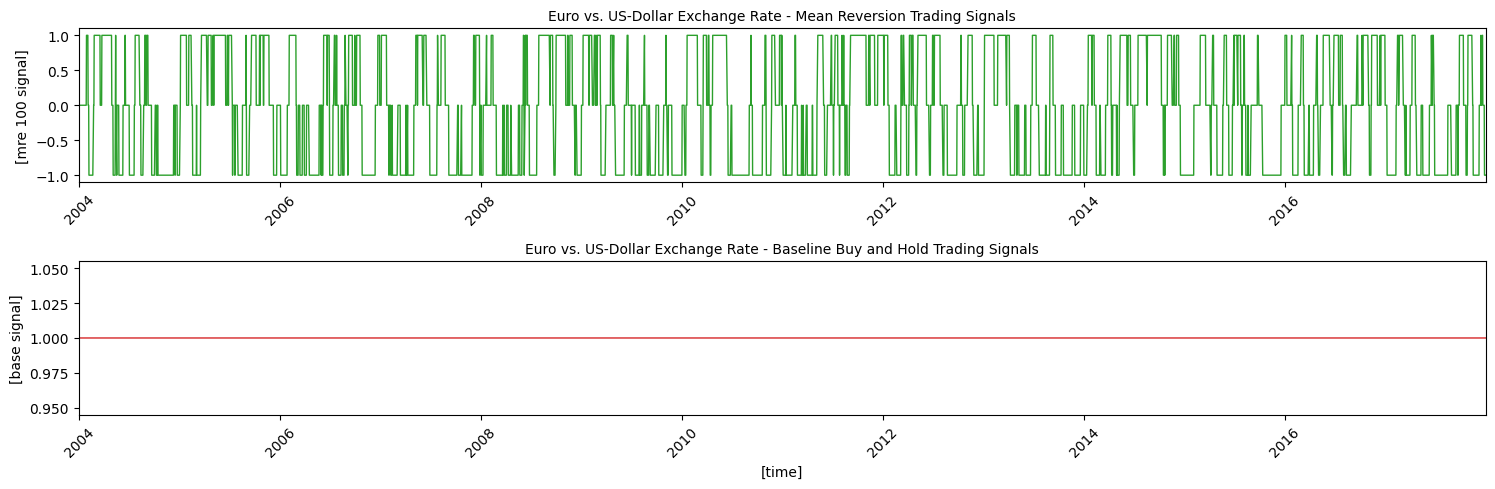

In [33]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=1, nrows=2)

ax[0].plot(mre_mav_eurusd_signal_data['SIGNAL_20'], lw=1.0, color='C2', label='SMAV 16 (red)')
ax[1].plot(mre_mav_eurusd_signal_data['SIGNAL_BASE'], lw=1.0, color='C3', label='BASE (purple)')

# set axis labels
plt.xlabel('[time]', fontsize=10)
ax[0].set_xlim([start_date, end_date])
ax[0].set_ylabel('[mre 100 signal]', fontsize=10)
ax[1].set_xlim([start_date, end_date])
ax[1].set_ylabel('[base signal]', fontsize=10)

# rotate the x-axis labels
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)

# set plot title
ax[0].set_title('Euro vs. US-Dollar Exchange Rate - Mean Reversion Trading Signals', fontsize=10)
ax[1].set_title('Euro vs. US-Dollar Exchange Rate - Baseline Buy and Hold Trading Signals', fontsize=10)

# reset plot layout
plt.tight_layout()

Let's determine the total number of **long-short signal changes** of the distinct trading strategies:

In [34]:
# signal changes of the mean-reversion trading strategy
len(list(it.groupby(mre_mav_eurusd_signal_data['SIGNAL_20'], lambda x: x > 0)))

267

In [35]:
# signal changes of the baseline buy and hold trading strategy
len(list(it.groupby(mre_mav_eurusd_signal_data['SIGNAL_BASE'], lambda x: x > 0)))

1

### 5. Mean Reversion Signal Backtest

Prepare the market data to be utilized in backtesting the mean reversion trading strategy:

In [36]:
# extract the eurusd exchange rate closing prices
eurusd_market_data = pd.DataFrame(eurusd_data['Adj Close'], columns=['Adj Close'])

# rename the 'close' column to 'eurusd' (since this is the column we want to allocate to in the backtest)
eurusd_market_data = eurusd_market_data.rename(columns={'Adj Close': 'EURUSD'})

# convert pandas DataFrame index to datatype: datetime
eurusd_market_data = eurusd_market_data.set_index(pd.to_datetime(eurusd_data.index))

Inspect top 10 rows of the prepared market data:

In [37]:
eurusd_market_data.head(10)

,EURUSD
Date,
2003-12-31,1.259002
2004-01-01,1.258194
2004-01-02,1.258194
2004-01-05,1.268698
2004-01-06,1.272103
2004-01-07,1.264095
2004-01-08,1.277498
2004-01-09,1.285892
2004-01-12,1.274096


Implementing a simple Mean Reversion Trading Strategy by interfacing the Python `bt`'s Algo class:

In [38]:
class MeanReversionStrategy(bt.Algo):

    # inits the strategy
    def __init__(self, signals):

        # set class signals
        self.signals = signals

    # calss the trading strategy
    def __call__(self, target):

        # case: current timestep in signals
        if target.now in self.signals.index[1:]:

            # get actual signal
            signal = self.signals[target.now]

            # set target weights according to signal
            target.temp['weights'] = dict(EURUSD=signal)

        # return 'True' since we want to move on to the next timestep
        return True

Define the moving average trading strategy backtest algorithm stack.

**Note:** That in the Python `bt` library a trading strategy usually consists of a so-called **stack of algorithms**. For each timestep of our backtest timeframe, the `bt` library executes all algorithm of the stack in sequential order. Each moving average strategy we aim to design and backtest consists in total of three algorithms, briefly described in the following:

> 1. `bt.algos.SelectAll()`: Selects all available stocks for trading except stock prices that correspond to NaN or 0.00.  
> 2. `MovingAverageStrategy()`: Assigns the calculated signal in terms of a weight value to the EUR vs. USD exchange rate.
> 3. `bt.algos.Rebalance()`: Rebalances the available capital based on the weights assigned to each stock.

Define the mean-reversion and buy-and-hold trading strategy backtest algorithm stack:

In [39]:
mre_mav_eurusd_strategy_20 = bt.Strategy(name='mre_20', algos=[bt.algos.SelectAll(), MeanReversionStrategy(mre_mav_eurusd_signal_data['SIGNAL_20']), bt.algos.Rebalance()])
mre_mav_eurusd_strategy_base = bt.Strategy(name='base', algos=[bt.algos.SelectAll(), MeanReversionStrategy(mre_mav_eurusd_signal_data['SIGNAL_BASE']), bt.algos.Rebalance()])

Let's now define the trading ('fees') commissions used in each rebalancing time-step of a backtest. To achieve this, the `bt` library expects a callable function that expects the following two parameters as an input:

> - the 'quantity', denoted by `q`, of rebalanced assets at a backtest time-step;
> - the 'price', denoted by `p`, of rebalanced assets at a backtest time-step.

Let's implement such a callable function defining a trading fee of **1\% (0.01)** per quantity of rebalanced asset (or a flat fee of **USD 5.00** per trade):

In [40]:
# init trading fees function
def trading_fees_function(q, p):

    # calcluate trading fees (rebalanced-quantity * trading-fee)
    fees = 5.00 # flat fee of USD 5.00 per trade

    # return the total trading fees
    return fees

Upon completion of defining the mean-reversion strategy let's now init the corresponding backtests using (1) both strategies as well as (2) the market data that we aim to evaluate during the backtest:

In [41]:
eurusd_backtest_mre_mav_20 = bt.Backtest(strategy=mre_mav_eurusd_strategy_20, data=eurusd_market_data, name='eurusd_backtest_mre_20', commissions=trading_fees_function, progress_bar=True)
eurusd_backtest_mre_mav_base = bt.Backtest(strategy=mre_mav_eurusd_strategy_base, data=eurusd_market_data, name='eurusd_backtest_mre_base', commissions=trading_fees_function, progress_bar=True)

Now, let's run the backtest of the mean-reversion trading strategy configuration as well as the defined baseline:

In [42]:
backtest_results_eurusd = bt.run(eurusd_backtest_mre_mav_20, eurusd_backtest_mre_mav_base)

eurusd_backtest_mre_20
0% [############################# ] 100% | ETA: 00:00:00eurusd_backtest_mre_base
0% [############################# ] 100% | ETA: 00:00:00

Inspect the individual backtest results and performance measures:

In [43]:
backtest_results_eurusd.display()

Stat                 eurusd_backtest_mre_20    eurusd_backtest_mre_base
-------------------  ------------------------  --------------------------
Start                2003-12-30                2003-12-30
End                  2017-12-29                2017-12-29
Risk-free rate       0.00%                     0.00%

Total Return         31.80%                    -5.09%
Daily Sharpe         0.24                      0.04
Daily Sortino        0.39                      0.06
CAGR                 1.99%                     -0.37%
Max Drawdown         -19.44%                   -35.01%
Calmar Ratio         0.10                      -0.01

MTD                  1.44%                     0.76%
3m                   2.17%                     1.36%
6m                   -1.08%                    4.91%
YTD                  -0.81%                    12.92%
1Y                   0.70%                     14.64%
3Y (ann.)            5.97%                     -0.63%
5Y (ann.)            4.50%                

Collect detailed backtest performance per timestep of the **mean-reversion** strategy:

In [44]:
backtest_mre_20_eurusd_details = eurusd_backtest_mre_mav_20.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_mre_20_eurusd_details['Abs. EQUITY'] = eurusd_backtest_mre_mav_20.strategy.values # equity per timestep
backtest_mre_20_eurusd_details['CASH'] = eurusd_backtest_mre_mav_20.strategy.cash # cash per timestep
backtest_mre_20_eurusd_details['POSITIONS'] = eurusd_backtest_mre_mav_20.strategy.positions # positions per timestep
backtest_mre_20_eurusd_details['FEES'] = eurusd_backtest_mre_mav_20.strategy.fees # trading fees per timestep

Inspect detailed backtest results per timestep:

In [45]:
backtest_mre_20_eurusd_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2003-12-30,100.0,1000000.0,1000000.0,0.0,0.0
2003-12-31,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-01,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-02,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-05,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-06,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-07,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-08,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-09,100.0,1000000.0,1000000.0,0.0,0.0
2004-01-12,100.0,1000000.0,1000000.0,0.0,0.0


Visualize the monthly returns obtained by the **mean-reversion** trading strategy:

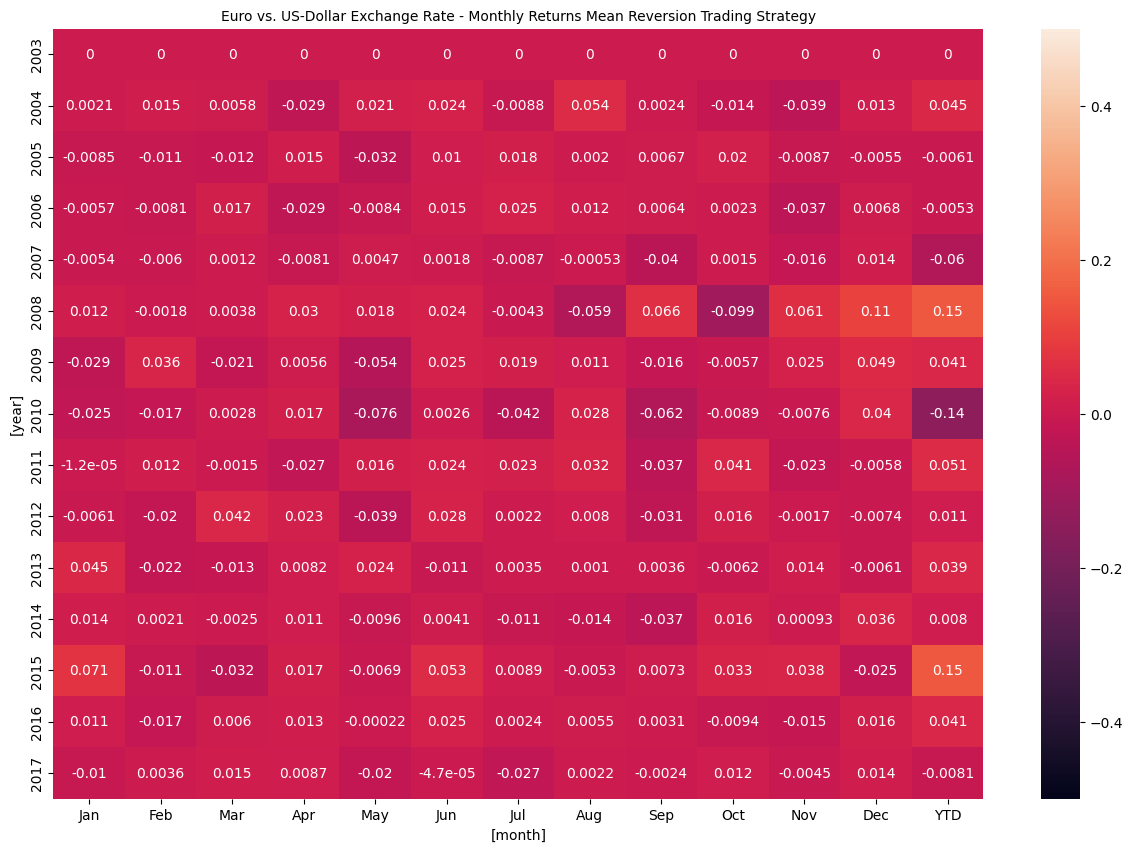

In [46]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(eurusd_backtest_mre_mav_20.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('Euro vs. US-Dollar Exchange Rate - Monthly Returns Mean Reversion Trading Strategy', fontsize=10);

Collect detailed backtest performance per timestep of the "long only" baseline strategy:

In [47]:
backtest_mre_base_eurusd_details = eurusd_backtest_mre_mav_base.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_mre_base_eurusd_details['Abs. EQUITY'] = eurusd_backtest_mre_mav_base.strategy.values # equity per timestep
backtest_mre_base_eurusd_details['CASH'] = eurusd_backtest_mre_mav_base.strategy.cash # cash per timestep
backtest_mre_base_eurusd_details['POSITIONS'] = eurusd_backtest_mre_mav_base.strategy.positions # positions per timestep
backtest_mre_base_eurusd_details['FEES'] = eurusd_backtest_mre_mav_base.strategy.fees # fees per timestep

Inspect detailed backtest results per timestep:

In [48]:
backtest_mre_base_eurusd_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2003-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2003-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2004-01-01,99.999500,9.999950e+05,0.047577,794786.0,5.0
2004-01-02,99.999500,9.999950e+05,0.047577,794786.0,0.0
2004-01-05,100.834306,1.008343e+06,0.047577,794786.0,0.0
2004-01-06,101.104957,1.011050e+06,0.047577,794786.0,0.0
2004-01-07,100.468483,1.004685e+06,0.047577,794786.0,0.0
2004-01-08,101.533767,1.015338e+06,0.047577,794786.0,0.0
2004-01-09,102.200939,1.022009e+06,0.047577,794786.0,0.0
2004-01-12,101.263391,1.012634e+06,0.047577,794786.0,0.0


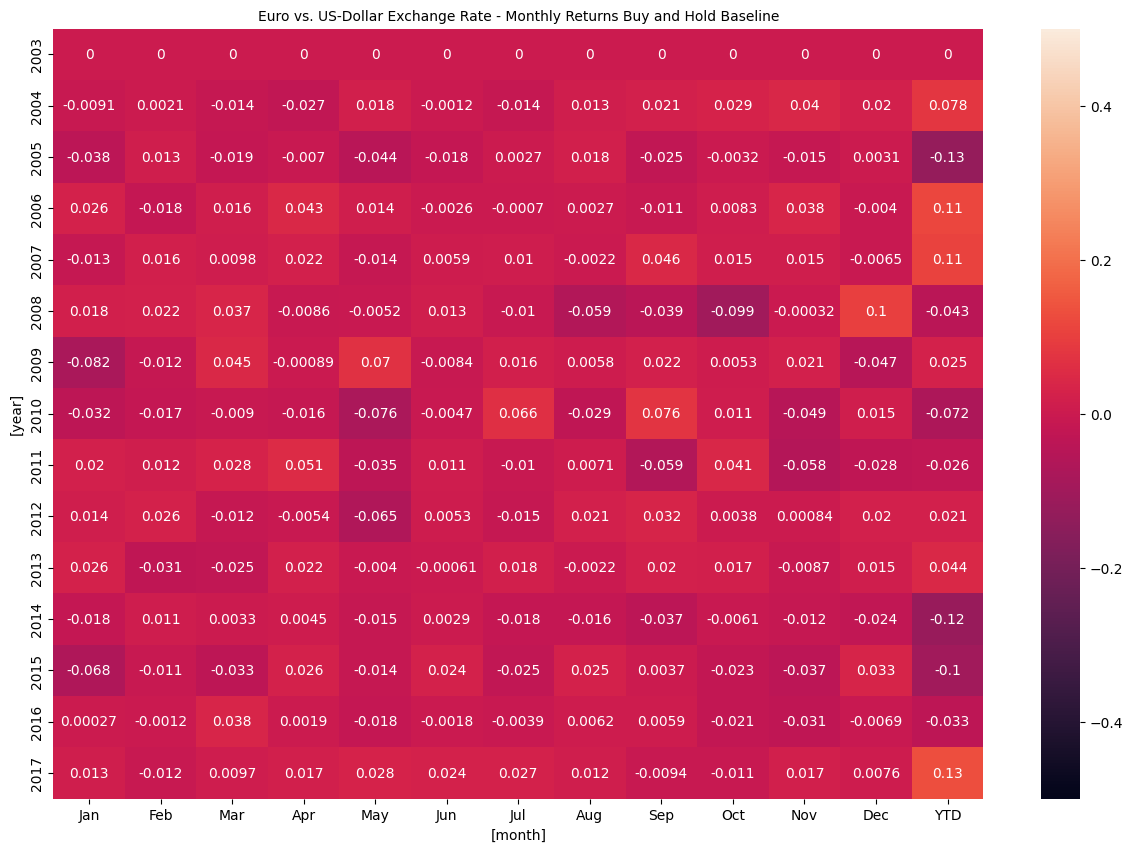

In [49]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(eurusd_backtest_mre_mav_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('Euro vs. US-Dollar Exchange Rate - Monthly Returns Buy and Hold Baseline', fontsize=10);

Visualize each strategie's backtest equity progression over time:

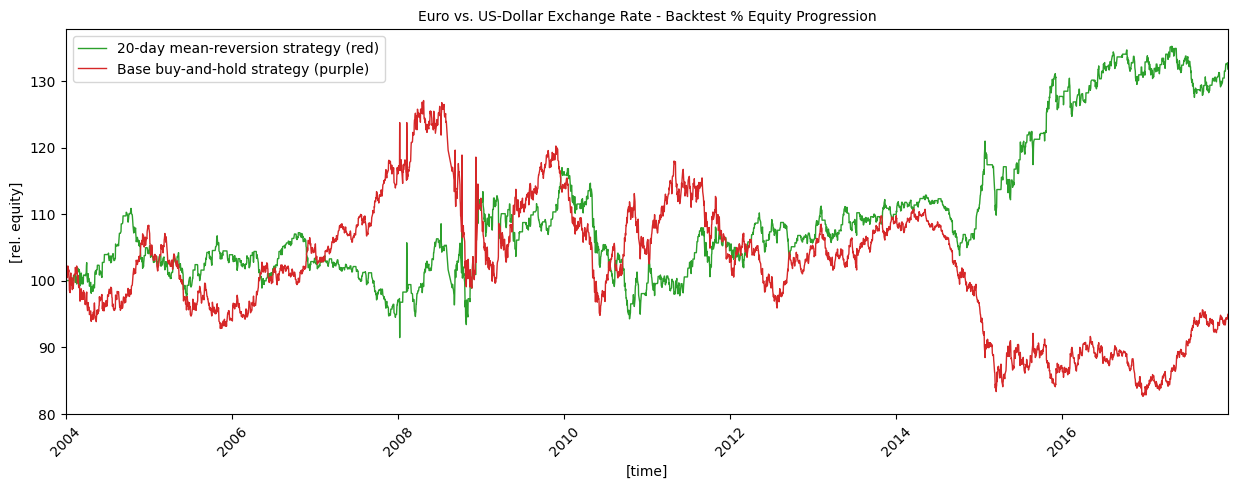

In [50]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot equity progression of the distinct trading strategies
ax.plot(backtest_mre_20_eurusd_details['Rel. EQUITY'], color='C2',lw=1.0, label='20-day mean-reversion strategy (red)')
ax.plot(backtest_mre_base_eurusd_details['Rel. EQUITY'], color='C3',lw=1.0, label='Base buy-and-hold strategy (purple)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[rel. equity]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('Euro vs. US-Dollar Exchange Rate - Backtest % Equity Progression', fontsize=10);

## Lab Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Evaluation of distinct daily moving average parameters.**

> Evaluate the mean-reversion trading strategy using distinct moving average look-backs, e.g., 10 days, 30 days, 50 days, 200 days and 300 days. Compare the performance of the lookback parametrizations in terms of total-return, equity progression and yearly sharpe-ratio. Gain an intuition about the years in which the strategy didn't perform well and the potential reason for the poor performance.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Evaluation of distinct Z-Score threshold parameters.**

>Evaluate the simple mean-reversion trading strategy using distinct Z-Score thresholds, e.g., $Z$ = 2, 3, 5, 10. Calculate the trading frequency of each parametrization and compare their performance in terms of total-return, equity progression and yearly-sharpe-ratio. Gain an intuition about the years in which the strategy didn't perform well and the potential reason of the poor performance.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**3. Consideration of trading commissions and impact on strategy performance.**

>Run the backtest of the lookback parametrizations evaluated in exercise 1. but change the commission per trade. Set the trading commission of each backtest to (i) 10 USD per trade and (ii) 1% of the price per share. Determine the impact of such a trading fee on the performance of each strategy in terms of total-return, equity progression and yearly sharpe-ratio.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**4. Optimization of the mean-reversion trading strategy parameters.**

>The lab notebook backtest results obtained for the mean-reversion trading strategy reveals that we did identify a well-performing strategy parametrization. However, there is definitely a "room for improvement". Grid search the parameter space of the strategy to determine a parametrization that results in a positive total-return within the time interval 31.12.2003 until 31.12.2017.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

## Lab Summary:

In this lab, a step by step implementation and backtest of a basic **mean-reversion trading strategy** using the Python programming language is presented. The implemented strategy trades a specific foreign exchange rate based on its adjusted closing price trend. The degree of success of the implemented strategy is evaluated based os its backtest results with particular focus on (1) the strategy's **total return** as well as (2) its **equity progression** over time. The code provided in this lab provides a blueprint to develop and backtest more complex trading strategies. It furthermore can be tailored to be applied for momentum trading of other financial instruments.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [ ]:
# installing the nbconvert library
!pip3 install nbconvert
!pip3 install jupyter_contrib_nbextensions

Let's now convert the Jupyter notebook into a plain Python script:

In [ ]:
!jupyter nbconvert --to script cfds_colab_04.ipynb